## Beta distribution things

In [6]:
%cd ..

/mounted/SS_DDPM


In [7]:
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torchvision
from scipy import interpolate
import sys
sys.path.append("..")
from dataclasses import dataclass

@dataclass
class Config:
    batch_size: int = 64 # Lower if OOM
    T: int = 1000
    device: str = "cuda"
    num_samples: int = 100000

cfg = Config()
batch_size = cfg.batch_size
T = cfg.T
device = cfg.device
num_samples=cfg.num_samples

In [8]:
from functools import partial
from schedule import noising_sch

noising_sch = partial(noising_sch, T=T)

from beta import KL, sufficient_stats, alpha_beta, get_dist, sufficient_stats_part2


## Training

In [9]:
from tqdm import tqdm
from torch.distributions.beta import Beta
import torch
import time

from utils import sample_t_batch

sample_t_batch = partial(sample_t_batch, T=T)

def sample_chain(t_batch, x_0):
    samples = []
    suff_stats = torch.zeros_like(x_0)
    t_min = torch.min(t_batch)
    helper = torch.Tensor([[t <= s for s in range(T + 1)] for t in t_batch]).to(device)
    
    for s in range(T, int(t_min), -1):
        s_batch = torch.tensor([s], device=device).repeat(batch_size)
        helper_slice = helper[:, s]
        
        theta = noising_sch(t_batch)
        
        alpha, beta = alpha_beta(theta, x_0)
        
        dist = Beta(alpha, beta)
        samples.append(dist.sample())
        
        suff_stats += helper_slice.reshape([-1, 1, 1, 1]) * sufficient_stats(samples[-1], s_batch)
    return samples, suff_stats

def sample_chain_suff_stats_norm_alpha(t_batch, x_0):
    samples = []
    suff_stats = torch.zeros_like(x_0)
    suff_stats_normed = torch.zeros_like(x_0)
    t_min = torch.min(t_batch)
    helper = torch.Tensor([[t <= s for s in range(T + 1)] for t in t_batch]).to(device)
    
    alphas = torch.zeros_like(x_0)
    
    for s in range(T, int(t_min), -1):
        s_batch = torch.tensor([s], device=device).repeat(batch_size)
        helper_slice = helper[:, s]
        
        mu = noising_sch(s_batch)
        
        dist = get_dist(mu, x_0)

        samples.append(dist.sample())
        alphas += helper_slice.reshape([-1, 1, 1, 1]) * mu.reshape([-1, 1, 1, 1]).repeat([1, 1, 28, 28])
        
        suff_stats += helper_slice.reshape([-1, 1, 1, 1]) * sufficient_stats(samples[-1], s_batch)
        
    suff_stats_normed = suff_stats / alphas
        
    return samples, suff_stats_normed


def train_sample_online(model, opt, dataloader, max_iter=1000):
    pbar = tqdm(range(max_iter))
    
    for i in pbar:
        x_0 = next(iter(dataloader))[0].to(device)
        t_batch = sample_t_batch(batch_size)
        
        start = time.time()
        
        noised_samples, suff_stats = sample_chain(t_batch, x_0)
        
        end = time.time()
        
        x_theta = model(suff_stats, t_batch)
        
        loss = KL(x_0, x_theta, t_batch).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_description(f'Iter {i} Loss: {loss.item()} Time for sample chain {end - start} s')
        if (i + 1) % 100 == 0:
            torch.save(model.state_dict(), f'beta_ddpm_{i}_iter.pth')


def train_generated_dataset(model, opt, dataloader, max_iter=1000):
    pbar = tqdm(range(max_iter))
    model.train()
    
    for i in pbar:
        x_0, t_batch, suff_stats = next(iter(dataloader))
        x_0, t_batch, suff_stats = x_0.to(device), t_batch.to(device), suff_stats.to(device)
        
        x_theta = model(suff_stats, t_batch)
        
        loss = KL(x_0, x_theta, t_batch).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_description(f'Iter {i} Loss: {loss.item():.4f}')
        if (i + 1) % 1000 == 0:
            torch.save(model.state_dict(), f'beta_ddpm_{i}_iter.pth')
        
def generate(model, filename='beta_ssddpm_samples.png'):
    model.eval()
    x_t = torch.rand([batch_size, 1, 28, 28]).to(device)
    suff_stats = sufficient_stats(x_t, torch.tensor([T], device=device).repeat(batch_size))
    
    for t in tqdm(range(T + 1, 1, -1)):
        t_batch = torch.tensor([t], device=device).repeat(batch_size)
        x_0 = model(suff_stats, t_batch)
        
        mu = noising_sch(t_batch)
        
        dist = get_dist(mu, x_0)
        x_t = dist.sample()
        suff_stats += sufficient_stats(x_t, torch.tensor([t - 1], device=device).repeat(batch_size))
        
    
    t_batch = torch.tensor([1], device=device).repeat(batch_size)
    x_0 = model(suff_stats, t_batch)
    
    img_grid = torchvision.utils.make_grid(x_0[:16] ,nrow= 4,normalize=True)
    
    torchvision.utils.save_image(img_grid, filename)
    
    return x_0


def generate_alpha_normed(model, filename='beta_ssddpm_samples.png'):
    model.eval()
    x_t = torch.rand([batch_size, 1, 28, 28]).to(device)
    suff_stats = sufficient_stats(x_t, torch.tensor([T], device=device).repeat(batch_size))
    alphas = noising_sch(torch.tensor([T], device=device).repeat(batch_size))
    
    suff_stats_normed = suff_stats / alphas.reshape([-1, 1, 1, 1]).repeat([1, 1, 28, 28])
    
    to_plot = []
    
    samples_history = []
    x_0_samples_history = []
    
    for t in tqdm(range(T, 1, -1)):
        t_batch = torch.tensor([t], device=device).repeat(batch_size)
        x_0 = model(suff_stats_normed, t_batch)
        
        mu = noising_sch(t_batch)
        alphas += mu
        
        dist = get_dist(mu, x_0)
        x_t = dist.sample()
        
        x_0_samples_history.append(x_0.detach().cpu())
        samples_history.append(x_t)
        
        alphas += mu
        
        suff_stats += sufficient_stats(x_t, torch.tensor([t - 1], device=device).repeat(batch_size))
        
        suff_stats_normed = suff_stats / alphas.reshape([-1, 1, 1, 1]).repeat([1, 1, 28, 28])
        to_plot.append(suff_stats_normed[:4, :, 10, 10].squeeze())
    
    t_batch = torch.tensor([1], device=device).repeat(batch_size)
    x_0 = model(suff_stats_normed, t_batch)
    
    img_grid = torchvision.utils.make_grid(x_0[:16] ,nrow= 4,normalize=True)
    
    torchvision.utils.save_image(img_grid, filename)
    
    return x_0, samples_history, x_0_samples_history


def generate_stats_normed(model, stats_norm_fn, filename='beta_ssddpm_samples.png'):
    model.eval()
    x_t = torch.rand([batch_size, 1, 28, 28]).to(device)
    suff_stats = sufficient_stats(x_t, torch.tensor([T], device=device).repeat(batch_size))
    alphas = noising_sch(torch.tensor([T], device=device).repeat(batch_size))
    suff_stats_normed = stats_norm_fn(suff_stats, torch.tensor([T], device=device).repeat(batch_size))
    
    to_plot = []
    
    samples_history = []
    x_0_samples_history = []
    
    for t in tqdm(range(T, 1, -1)):
        t_batch = torch.tensor([t], device=device).repeat(batch_size)
        x_0 = model(suff_stats_normed, t_batch)
        
        mu = noising_sch(t_batch)
        alphas += mu
        
        dist = get_dist(mu, x_0)
        x_t = dist.sample()
        
        x_0_samples_history.append(x_0.detach().cpu())
        samples_history.append(x_t)
        
        alphas += mu
        
        suff_stats += sufficient_stats(x_t, torch.tensor([t - 1], device=device).repeat(batch_size))
        
        suff_stats_normed = stats_norm_fn(suff_stats, t_batch)
        to_plot.append(suff_stats_normed[:4, :, 10, 10].squeeze())
    
    t_batch = torch.tensor([1], device=device).repeat(batch_size)
    x_0 = model(suff_stats_normed, t_batch)
    
    img_grid = torchvision.utils.make_grid(x_0[:16] ,nrow= 4,normalize=True)
    
    torchvision.utils.save_image(img_grid, filename)
    
    return x_0, samples_history, x_0_samples_history



## MNIST

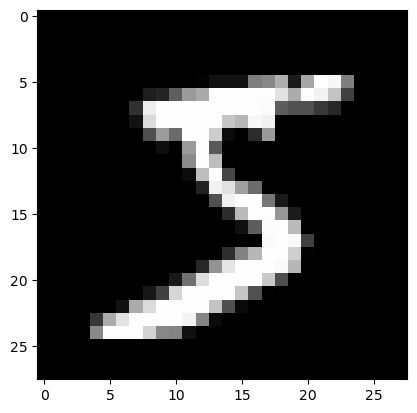

In [10]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

dataset = MNIST(root='MNIST', download=True,transform=transforms.Compose([transforms.ToTensor()]))
plt.imshow(dataset[0][0].squeeze(), cmap='gray')

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
from src.diffusion_dataset_base import load_generated_dataset

forward_diffusion_dataset = load_generated_dataset()
forward_diffusion_dataloader = torch.utils.data.DataLoader(forward_diffusion_dataset, batch_size=batch_size, shuffle=True)

## Model

In [12]:
import torch.nn.functional as F
from models import UNet

model = UNet(1, 32, (1, 2, 4), time_emb_dim=16)

class BetaUnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = UNet(1, 32, (1, 2, 4), time_emb_dim=16)

    def forward(self, suff_stats, t):
        return F.sigmoid(self.model(suff_stats, t))

model = BetaUnet()
model = model.to(device)
model.load_state_dict(torch.load('beta_ddpm_the_best_100k_alpha_normed_0.pth'))

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [31]:

train_generated_dataset(model, opt, forward_diffusion_dataloader, max_iter=40000)


Iter 5214 Loss: 0.0009:  13%|███▏                    | 5215/40000 [06:43<44:48, 12.94it/s]


KeyboardInterrupt: 

In [43]:
# torch.save(model.state_dict(), 'beta_ddpm_the_best_100k_alpha_normed_0.pth')

## Backward Diffusion

100%|███████████████████████████████████████████████████| 999/999 [00:24<00:00, 40.26it/s]


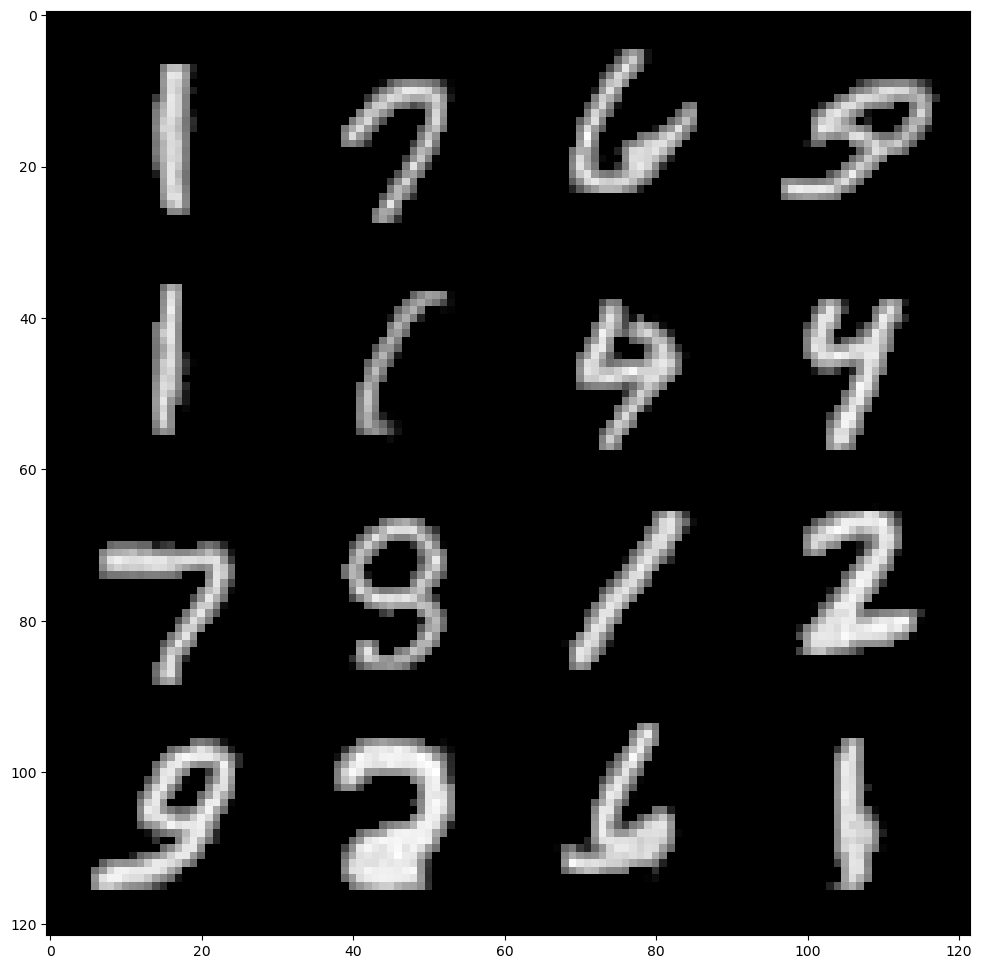

In [13]:
samples, samples_history, x_0_samples_history = generate_alpha_normed(model)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

plt.figure(figsize = (12,12))

img = np.asarray(Image.open('beta_ssddpm_samples.png'))
imgplot = plt.imshow(img, cmap='gray')

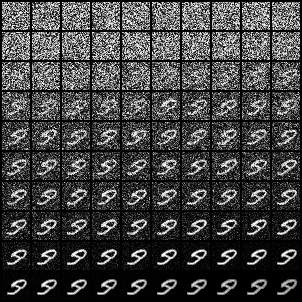

In [17]:
# samples_history[0].shape

img_grid = torchvision.utils.make_grid(torch.cat([item[3] for item in samples_history[::10]], dim=0).unsqueeze(1) ,nrow=10,normalize=True)
torchvision.transforms.ToPILImage()(img_grid)

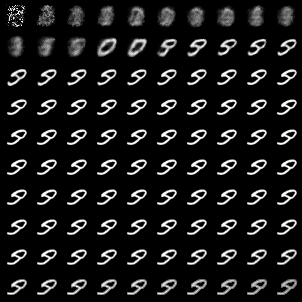

In [18]:
# samples_history[0].shape

img_grid = torchvision.utils.make_grid(torch.cat([item[3] for item in x_0_samples_history[::10]], dim=0).unsqueeze(1) ,nrow=10,normalize=True)
torchvision.transforms.ToPILImage()(img_grid)

## Visualization of Forward Diffusion

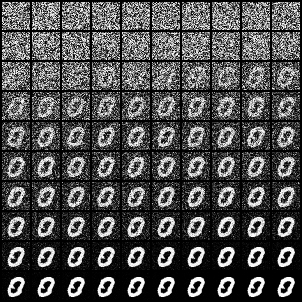

In [16]:

t_batch = torch.tensor([0], device=device).repeat(batch_size)

x_0 = next(iter(dataloader))[0].to(device)
samples, suff_stats_normed = sample_chain_suff_stats_norm_alpha(t_batch, x_0)

img_grid = torchvision.utils.make_grid(torch.cat([item[0] for item in samples[::10]], dim=0).unsqueeze(1) ,nrow=10,normalize=True)
torchvision.transforms.ToPILImage()(img_grid)

### Compute FID

In [32]:
print('somethi')

somethi


100%|███████████████████████████████████████████████████| 938/938 [00:57<00:00, 16.31it/s]


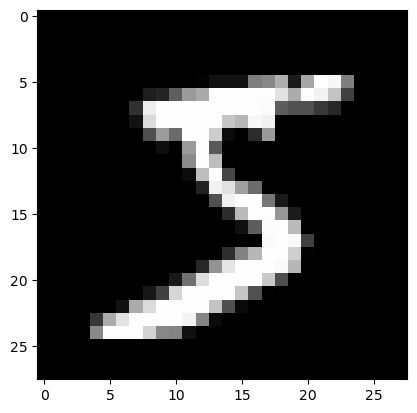

In [20]:

from torchmetrics.image.fid import FrechetInceptionDistance as FID
fid = FID(normalize=True).to(device)


dataset = MNIST(root='MNIST', download=True,transform=transforms.Compose([transforms.ToTensor()]))

mnist_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for data in tqdm(iter(mnist_dataloader)):
    
    fid.update(data[0].to(device).repeat([1, 3, 1, 1]), real=True)
    

In [24]:
n_samples = 1000
for i in range(n_samples // batch_size + 1):
    samples, samples_history, x_0_samples_history = generate_alpha_normed(model)
    
    fid.update(samples.repeat([1, 3, 1, 1]), real=False)
    

100%|██████████████████████████████████████████████████| 999/999 [00:09<00:00, 105.18it/s]


In [25]:
fid.compute()

tensor(29.6419, device='cuda:0')

## Some functions for statistics normed Tail Conditioning (isn't working properly yet)

In [101]:
import torch

class ForwardDiffusionDatasetStatsNormed(torch.utils.data.Dataset):
    def __init__(self, x_0_tensor, t_batch_tensor, suff_stats_tensor, data_stats):
        super().__init__()
        self.x_0_tensor = x_0_tensor
        self.t_batch_tensor = t_batch_tensor
        self.suff_stats_tensor = suff_stats_tensor
        self.g_mean = data_stats['g_mean']
        for t in range(T + 1):
            if self.g_mean[t] == 0:
                print('Zero!', t)
        
        self.g_std = data_stats['g_std']
        self.suff_stats_part2_mean = data_stats['suff_stats_part2_mean']
        self.suff_stats_part2_std = data_stats['suff_stats_part2_std']
        
    def __len__(self):
        return self.x_0_tensor.shape[0]
        
    def __getitem__(self, idx):
        suff_stats = self.stats_norm_fn(self.suff_stats_tensor[idx], self.t_batch_tensor[idx])
        
        return self.x_0_tensor[idx], self.t_batch_tensor[idx], self.suff_stats_tensor[idx]
    
    def stats_norm_fn(self, G_t, t):
        if len(t.shape) == 0:
            t = int(t)
        else:
            t = int(t[0])
#         print(self.g_mean[t], self.g_std[t], self.suff_stats_part2_std, self.suff_stats_part2_mean )
        return (G_t - self.g_mean[t]) * self.suff_stats_part2_std / self.g_std[t] + self.suff_stats_part2_mean
    
def load_generated_dataset_stats_normed():
    x_0_tensor, t_batch_tensor, suff_stats_tensor = torch.load('x_0_dataset.pth'), torch.load('t_batch_dataset.pth'), torch.load('suff_stats_dataset.pth')
    data_stats = torch.load('dataset_beta_stats.pth')
    
    return ForwardDiffusionDatasetStatsNormed(x_0_tensor, t_batch_tensor, suff_stats_tensor, data_stats)

dataset = load_generated_dataset_stats_normed()


Zero! 0
